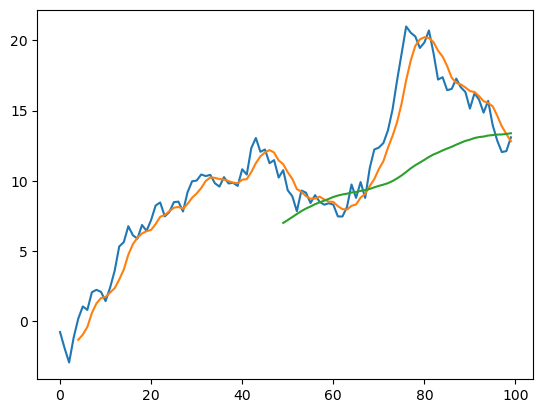

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x = np.random.normal(0, 1, 100)
x_cumsum = np.cumsum(x)
x_cumsum_series = pd.Series(x_cumsum)

plt.plot(x_cumsum_series)
plt.plot(x_cumsum_series.rolling(5).mean())
plt.plot(x_cumsum_series.rolling(50).mean())

***데이터 시뮬레이션***

In [16]:
import numpy as np

# 회원상태
years = ['2014', '2015', '2016', '2017', '2018']
membersStatus = ['bronze', 'silver', 'gold', 'inactive']

# np.random.choice로 일어날 확률 조절
memberYears = np.random.choice(years, 1000, p=[.1, .1, .15, .3, .35])
memberStats = np.random.choice(membersStatus, 1000, p=[.5, .3, .1, .1])
yearJoined = pd.DataFrame({
    'yearJoined' : memberYears,
    'memberStats' : memberStats
})

In [259]:
# 회원의 이메일 열람 시점을 나타내는 테이블 
NUM_EMAILS_SENT_WEEKLY = 3

# 서로 다른 패턴을 위한 몇가ㅣ 함수 정의
def never_opens(period_rng):
    return []

def constant_open_rate(period_rng):
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0,1)
    num_opended = np.random.binomial(n, p, len(period_rng))
    return num_opended

def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))

def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

def open_rate_with_factor_change(period_rng, fac):
    if len(period_rng):
        return []
    times = np.random.randint(0, len(period_rng), int(0.1*len(period_rng)))
    num_opened = np.zeros(len(period_rng))
    for prd in range(0, len(period_rng), 2):
        try:
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0,1)
            num_opened[prd:(prd+2)] = np.random.binomial(n, p, 2)
            p = max(min(1,p*fac), 0)
        except:
            num_opened[prd] = np.random.binomial(n, p, 1)
    
    for t in range(len(tiems)):
        num_opened[times[t]] = 0
    return num_opened

In [263]:
# 기부행동 모델링
def produce_donations(period_rng, member_behavior, num_emails, user_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 
                                 1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY * len(period_rng))
    member_gives = member_has * email_fraction
    member_gives_idx = np.where(member_gives >= donation_amounts)[0][-1]
    member_gives_idx = max(min(member_gives_idx, len(donation_amounts) - 2), 1)
    
    num_times_gave = np.random.poisson(2) * (2018 - member_join_year)
    times = np.random.randint(0, len(period_rng), num_times_gave)
    
    dons = pd.DataFrame({
        'member' : [],
        'amount' : [],
        'timestamp' : []
    })
    
    for n in range(num_times_gave):
        donation = donation_amounts[member_gives_idx + np.random.binomial(1, .3)]
        ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame({
            'member' : [user_id],
            'amount' : [donation],
            'timestamp' : [ts]
        }))
        
    if dons.shape[0] > 0:
        dons = dons[dons.amount != 0] # 기부액이 0인 경우 보고 X
        
        return dons

In [264]:
# 각 회원이 기부를 한 주와 각 주내에 기부를 한 시점을 고르는 시뮬레이션 코드
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11,23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]
    return pd.Timedelta(str(np.random.choice(days_of_week)) + 'days') +\
           pd.Timedelta(str(np.random.choice(hours_of_day)) + 'hours') +\
           pd.Timedelta(str(np.random.choice(minute_of_hour)) + 'minutes') +\
           pd.Timedelta(str(np.random.choice(second_of_minute)) + 'seconds')


In [266]:
# 코드를 한곳으로 모음
behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasing_open_rate]
member_behaviors = np.random.choice(behaviors, 1000, [.2, .5, .1, .2])

rng = pd.period_range('2015-02-14', '2018-06-01', freq='w')
emails = pd.DataFrame({
    'member' : [],
    'week' : [],
    'emailsOpened' : []
})
donations = pd.DataFrame({
    'member' : [],
    'amount' : [],
    'tunestamp' : []
})

for idx in range(yearJoined.shape[0]):
    # 회원이 가입한 시기 무작위로 생성
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) +\
                pd.Timedelta(str(np.random.randint(0, 365)) + 'days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))
    
    # 가입 전에는 어떤 행동에 대한 타임스탬프가 없어야 합니다.
    member_rng = rng[rng.start_time > join_date]
    
    if len(member_rng) < 1:
        continue
        
    info = member_behaviors[idx](member_rng)
    if len(info) == len(member_rng):
        emails = emails.append(pd.DataFrame({
            'member' : [idx] * len(info),
            'week' : [str(r.start_time) for r in member_rng],
            'emailsOpened' : info
        }))
        donations = donations.append(
            produce_donations(member_rng, member_behaviors[idx],
                              sum(info), idx, join_date.year)
        )

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFr

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFr

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.Data

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({


/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({


/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFr

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.Da

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFram

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({


/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/v

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/v

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({


/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/v

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFram

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({


/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.Da

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({


/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({


/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFram

/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/2787063367.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({
/var/folders/yr/nt9qv8x55mv3g666qst4sx980000gn/T/ipykernel_68877/32290269.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFram

<AxesSubplot:xlabel='timestamp'>

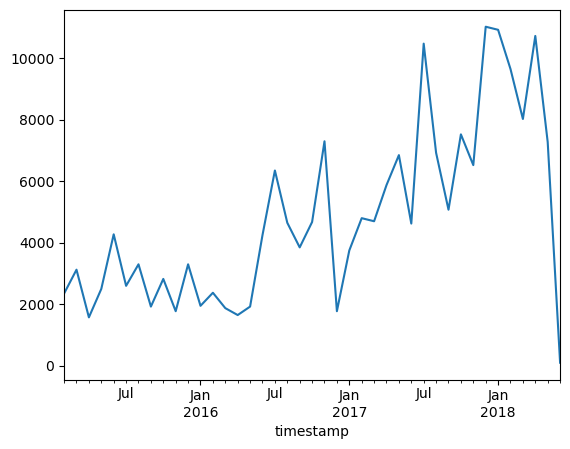

In [267]:
df = donations
df.set_index(pd.to_datetime(df.timestamp), inplace = True)
df.sort_index(inplace=True)
df.groupby(pd.Grouper(freq='M')).amount.sum().plot()

***스스로 실행하는 시뮬레이션 세계 구축***

In [551]:
# 택시 식별번호 생성
import numpy as np

def taxi_id_number(num_taxis):
    arr = np.arange(num_taxis)
    np.random.shuffle(arr)
    for i in range(num_taxis):
        yield arr[i]


In [552]:
# 각 교대 시간을 나타내는 제네레이터 
def shift_info():
    # 하루의 서로 다른 세 개의 교대 시간대를 표현
    # 시간 : 0, 8, 16, 빈도 : 8, 30, 15
    start_times_and_freqs = [(0,8), (8,30), (16,15)]
    indices = np.arange(len(start_times_and_freqs))
    while True:
        idx = np.random.choice(indices, p=[0.25, 0.5, 0.25])
        start = start_times_and_freqs[idx]
        yield (start[0], start[0]+7.5, start[1])

In [553]:
# 개별 택시의 파라미터를 설정하고 시간표를 생성하는 좀 더 복잡한 제네레이터
def taxi_process(taxi_id_generator, shift_info_generator):
    taxi_id = next(taxi_id_generator)
    shift_start, shift_end, shift_mean_trips = next(shift_info_generator)
    actual_trips = round(np.random.normal(loc=shift_mean_trips, scale=2))
    average_trip_time = 6.5 / shift_mean_trips * 60
    # 평균 운행 시간을 분 단위로 변환
    between_events_time = 1.0 / (shift_mean_trips-1)*60
    # 이 도시는 효율적이어서 모든 택시가 거의 항상 사용됨.
    time = shift_start
    yield TimePoint(taxi_id, 'start_shift', time)
    deltaT = np.random.poisson(between_events_time) / 60
    time += deltaT
    for i in range(actual_trips):
        yield TimePoint(taxi_id, 'pick up', time)
        deltaT = np.random.poisson(average_trip_time) / 60
        time += deltaT
        yield TimePoint(taxi_id, 'drop off', time)
        deltaT = np.random.poisson(between_events_time) / 60
        time += deltaT
    deltaT = np.random.poisson(between_events_time) / 60
    time += deltaT
    yield TimePoint(taxi_id, 'end shift', time)

In [554]:
# TimePoint
from dataclasses import dataclass

@dataclass
class TimePoint:
    taxi_id : int
    name: str
    time: float
    
    def __lt__(self, other):
        return self.time < other.time

In [590]:
# 시뮬레이터 클래스
import queue

class Simulator:
    def __init__(self, num_taxis):
        self._time_points = queue.PriorityQueue()
        taxi_id_generator = taxi_id_number(num_taxis)
        shift_info_generator = shift_info()
        self._taxis = [taxi_process(taxi_id_generator, shift_info_generator)
                       for i in range(num_taxis)]
        self._prepare_run()
        
    def _prepare_run(self):
        for t in self._taxis:
            while True:
                try:
                    e = next(t)
                    self._time_points.put(e)
                except:
                    break
                    
    def run(self):
        sim_time = 0
        while sim_time < 24:
            if self._time_points.empty():
                break
            p = self._time_points.get()
            sim_time = p.time
            print(p)

In [633]:
# 시뮬레이션 실행
sim = Simulator(100)
sim.run()

TimePoint(taxi_id=77, name='start_shift', time=0)
TimePoint(taxi_id=48, name='start_shift', time=0)
TimePoint(taxi_id=49, name='start_shift', time=0)
TimePoint(taxi_id=28, name='start_shift', time=0)
TimePoint(taxi_id=30, name='start_shift', time=0)
TimePoint(taxi_id=72, name='start_shift', time=0)
TimePoint(taxi_id=91, name='start_shift', time=0)
TimePoint(taxi_id=50, name='start_shift', time=0)
TimePoint(taxi_id=36, name='start_shift', time=0)
TimePoint(taxi_id=78, name='start_shift', time=0)
TimePoint(taxi_id=22, name='start_shift', time=0)
TimePoint(taxi_id=59, name='start_shift', time=0)
TimePoint(taxi_id=0, name='start_shift', time=0)
TimePoint(taxi_id=31, name='start_shift', time=0)
TimePoint(taxi_id=90, name='start_shift', time=0)
TimePoint(taxi_id=25, name='start_shift', time=0)
TimePoint(taxi_id=27, name='start_shift', time=0)
TimePoint(taxi_id=58, name='start_shift', time=0)
TimePoint(taxi_id=12, name='start_shift', time=0)
TimePoint(taxi_id=5, name='start_shift', time=0)
Ti